# Testing framework "pipeline"

_Alex Malz (NYU)_

In [1]:
import string
import itertools
import random
import numpy as np
import scipy.stats as sct
import scipy.integrate as spi
import sklearn as skl
from sklearn import metrics
from pycm import ConfusionMatrix
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import proclam
# from proclam import *

## 1. True classes

Import the `proclam.Simulator` superclass and the simulator subclass you want to test.  In this notebook, I'm going to use an unbalanced distribution of true classes such that the probability of an object being in class $m$ (with $0 \leq m \leq M$) is proportional to $10^{y}$, where $y$ is a draw from a uniform distribution $U(0,M)$.

In [3]:
from proclam.simulators import simulator
from proclam.simulators import logunbalanced

Create an instantiation of the simulator for the true dataset class distribution scheme.  If you use the base superclass instead of a subclass, the default scheme will be to assign all objects the same class.

In [4]:
A = proclam.simulators.logunbalanced.LogUnbalanced()

Then, simulate a truth catalog.  In this case, there are 3 true classes and 100 objects in the catalog.  The output will be a `numpy.ndarray` with 100 entries, each of which is the index of the class for that catalog member.

In [5]:
A = proclam.simulators.logunbalanced.LogUnbalanced(seed=None)
M_classes = 5
N_objects = 1000
names = [''.join(random.sample(string.ascii_lowercase, 2)) for i in range(M_classes)]
truth = A.simulate(M_classes, N_objects, base=2)

We can check that the class distribution is as expected with a histogram of the true classes.

Text(0.5, 0, 'class')

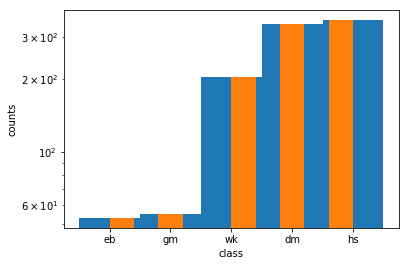

In [6]:
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True)
plt.xticks(range(max(truth)+1), names)

plt.hist(truth, log=True)
plt.ylabel('counts')
plt.xlabel('class')

In [7]:
def save_info(truth, df, name, seed=0):
    pathname = "examples/ProClaM/"+name+"/"
    if os.path.isdir(pathname) == False:
        os.system('mkdir '+ pathname)
    df.to_csv(pathname + "predicted_prob_"+name+".csv", sep=' ', index=False, header=False)
    truth_mask = proclam.metrics.util.det_to_prob(truth)
    fileloc = pathname + 'truth_table_'+name+'.csv'
    np.savetxt(fileloc, truth_mask, delimiter=' ')
    return

## 2. Mock classifications

Import the `proclam.Classifier` superclass and the classifier subclass you want to test.  In this notebook, I'm going to use a very stupid classifier that takes a random guess.

In [8]:
from proclam.classifiers import classifier
from proclam.classifiers import guess
from proclam.classifiers import from_cm

Create an instantiation of the classifier of a particular scheme.  If you use the base superclass instead of a subclass, the default classification scheme will return the true classes.

Then, "classify" the "data."  By default, classification results will also include an extra column for "other" classes beyond the number in the training set, but in this example let's assume it knows of the M classes in the training set without leaving room for additional classes.  The output will be a `numpy.ndarray` with N rows and column entries representing each catalog member's posterior probability for being of each class.

In [9]:
B = proclam.classifiers.guess.Guess(seed=None)
predictionB = B.classify(M_classes, truth, other=False)
save_info(truth, pd.DataFrame(predictionB), 'Guess', seed=0)
# print(prediction)

Let's compare this to a smarter classifier based on a confusion matrix.

[[0.77459445 0.11209536 0.06052605 0.00362192 0.07104932]
 [0.11003839 0.80009249 0.01965666 0.02884268 0.01506941]
 [0.09383029 0.07687496 0.65189991 0.07650355 0.12909478]
 [0.12409745 0.0805176  0.00174395 0.75464134 0.06014014]
 [0.06169615 0.08333079 0.04914953 0.02018145 0.77150318]]


Text(0, 0.5, 'true class')

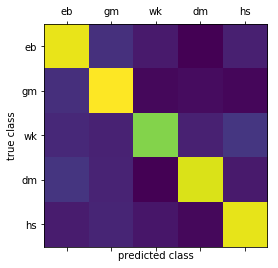

In [10]:
cm = np.eye(M_classes) + 0.2 * np.random.uniform(size=(M_classes, M_classes))
cm /= np.sum(cm, axis=1)
print(cm)
np.flip(cm,0)
plt.matshow(cm)#, vmin=0., vmax=1.)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')

We want to support classifiers with an extra class for classes not represented in the training set, but the infrastructure isn't there yet.

In [11]:
C = proclam.classifiers.from_cm.FromCM(seed=None)
predictionC = C.classify(cm, truth, other=False)
print(predictionC)
save_info(truth, pd.DataFrame(predictionC), 'Idealized', seed=0)

[[0.11284647 0.80101817 0.03185446 0.03936846 0.01491243]
 [0.09973749 0.07725771 0.60755048 0.08775271 0.12770162]
 [0.08582221 0.08195349 0.05213019 0.02797892 0.75211519]
 ...
 [0.07873401 0.08532457 0.05993838 0.03413578 0.74186726]
 [0.05587737 0.46613713 0.36092296 0.04309275 0.0739698 ]
 [0.09950859 0.07750803 0.61382232 0.07556721 0.13359384]]


We can also try this with real data from `SNPhotCC`.

In [12]:
# old_snphotcc_names = []
# for prefix in ['templates_', 'wavelets_']:
#     for suffix in ['boost_forest', 'knn', 'nb', 'neural_network', 'svm']:
#         old_snphotcc_names.append(prefix+suffix+'.dat')

# snphotcc = {}
# snphotcc['label'] = 'SNPhotCC'
# prefixes = ['Templates', 'Wavelets']
# suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
# snphotcc['names'] = []
# for prefix in prefixes:
#     for suffix in suffixes:
#         snphotcc['names'].append(prefix+suffix)
# snphotcc['dirname'] = 'examples/' + snphotcc['label'] + '/'

# truthloc = 'examples/SNPhotCC/key.txt'
# truth_snphotcc = pd.read_csv(truthloc, sep=' ')
# # truth_snphotcc -= 1.
# # truth_snphotcc = truth_snphotcc.astype(int)[:N_objects]
# # truth_snphotcc = pd.DataFrame(truth_snphotcc)

# for i in range(len(snphotcc['names'])):
#     name = old_snphotcc_names[i]
#     fileloc = 'examples/SNPhotCC/classifications/'+name
#     snphotcc_info = pd.read_csv(fileloc, sep=' ')
#     full = snphotcc_info.set_index('Object').join(truth_snphotcc.set_index('Object'))
#     name = snphotcc['names'][i]
    
#     snphotcc_truth = full['Type'] - 1
#     snphotcc_truth_table = proclam.metrics.util.det_to_prob(snphotcc_truth)
#     fileloc = snphotcc['dirname']+name+'/truth_table_'+name+'.csv'
#     np.savetxt(fileloc, snphotcc_truth_table, delimiter=' ')
    
#     probs = full[['1', '2', '3']]
#     fileloc = snphotcc['dirname']+name+'/predicted_prob_'+name+'.csv'
#     probs.to_csv(fileloc, sep=' ', index=False, header=False)

In [13]:
# print(snphotcc_info)
# print(truth_snphotcc)
# print(full)

In [14]:
# probs = np.loadtxt('examples/classifications/templates_knn.dat', usecols=[1, 2, 3], skiprows=1)
# # print(np.shape(probs))
# probs = probs[:N_objects]
# # print(np.shape(probs))

# # truth_snphotcc = np.loadtxt('examples/key.txt', usecols=[1], skiprows=1)
# # truth_snphotcc -= 1.
# # truth_snphotcc = truth_snphotcc.astype(int)[:N_objects]
# # truth_snphotcc = pd.DataFrame(truth_snphotcc)

# CM = proclam.metrics.util.prob_to_cm(probs, truth_snphotcc, vb=True)
# # print(CM)
# plt.matshow(CM)#, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1)[:3], names[:3])
# plt.yticks(range(max(truth)+1)[:3], names[:3])
# plt.xlabel('predicted class')
# plt.ylabel('true class')

# F = proclam.classifiers.from_cm.FromCM(seed=None)
# predictionF = F.classify(CM, truth_snphotcc, other=False)

Below is tunnel vision classifier which means that it performs well on one class only and classifies other classes agnostically so it might classify other classes correctly by chance. The class that is classified correctly is chosen in the code randomly each time.

There are different scenarios for the confusion matrix which are discussed and shown below:

**1) Tunnel classifier CM:** 

This is where the confusion matrix has one class that has a high value on the diagnoal and small value on the off-diagonal elements for that specific class and has small values for the diagonal component of other classes or 1/M value for all entries (classifies y chance)

In [15]:
# N = 3 #len(truth)
# M = len(cm)
#if other: M += 1
CM = np.zeros((M_classes, M_classes))
class_corr = np.array([2]) #np.random.randint(0, M_classes, size=1) # randomly choose which class to work well on

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[class_corr[0]][class_corr[0]] = np.random.uniform(1./M_classes, 1., 1)
        
print(CM)
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMtunnel = CM

# saving probabilities
G           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionG = G.classify(CMtunnel, truth, other=False)
df          = pd.DataFrame(predictionG)
save_info(truth, df, 'Tunnel', seed=0)

[[0.15842418 0.18857113 0.16013153 0.17989965 0.01515237]
 [0.17176994 0.13661988 0.13941695 0.09105078 0.10789923]
 [0.17019976 0.06886277 0.77397623 0.01511753 0.06713813]
 [0.04351717 0.12580389 0.14106496 0.06285216 0.11175521]
 [0.06891721 0.0174588  0.12293988 0.07999228 0.12880625]]


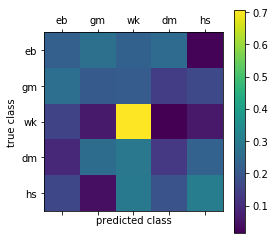

In [16]:
plt.matshow(CMtunnel)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**2) Broadbrush classifier CM:** 

This is where the confusion matrix takes thre most populous class and classifies that one correctly. This is very similar to tunnel classifier except that we kow which class it will classify correctly and it is not randomly chosen.

In [17]:
CM = np.zeros((M_classes, M_classes))
class_corr = sct.mode(truth)[0] #takes the most common class

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[class_corr[0]][class_corr[0]] = np.random.uniform(1./M_classes, 1., 1)
        
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMbroadbrush = CM

# saving probabilities
H           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionH = H.classify(CMbroadbrush, truth, other=False)
df          = pd.DataFrame(predictionH)

save_info(truth, df, 'Broadbrush', seed=0)

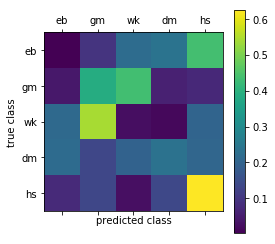

In [18]:
plt.matshow(CMbroadbrush)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**3) Cruise control classifier CM:** 

This is where the confusion matrix has high values on the column of one specific class which means that the classifier constantly classifies all entries as one specific class

In [19]:
CM = np.zeros((M_classes, M_classes))
class_corr = 2 #np.random.randint(0, M_classes, size=1) # randomly choose which class to classify all class on

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[i][class_corr] = np.random.uniform(1./M_classes, 1., 1)
        
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMcruise = CM

# saving probabilities
I = proclam.classifiers.from_cm.FromCM(seed=None)
predictionI = I.classify(CMcruise, truth, other=False)
df          = pd.DataFrame(predictionI)

save_info(truth, df, 'Cruise', seed=0)

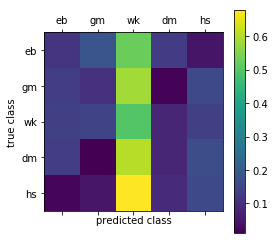

In [20]:
plt.matshow(CMcruise)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**4) Subsumed classifier CM:** 

This is where the classifier consistently classifies class M and class M'. So, the confusion matrix will have a higher value on the element on row M and column M' compared to other values in that row so that it is misclassified most of the times. Other classes may be classified correctly randomly as I assign them random uniform values between 0 and 1. There could be more restriction on the other classes if we want.

In [21]:
CM = np.zeros((M_classes, M_classes))
class_M      = 1 #np.random.randint(0., M_classes, size=1)[0]
class_Mprime = 2 #np.random.randint(0., M_classes, size=1)[0]

#This is to make sure we do not misclassify class M with the same class (which makes no sense)
n = 0
while class_M == class_Mprime:
    n+=1
    print(("going in to the loop", n, "times!"))
    class_Mprime = np.random.randint(0., M_classes, size=1)

CM = cm.copy()#np.random.uniform(0., 1, 1)
CM[class_M] = CM[class_Mprime]
# for i in range(M_classes):
#     for j in range(M_classes):
#         CM[i][j] = np.random.uniform(0, 1., 1)
#         CM[class_M][class_Mprime]  = np.random.uniform(1./M_classes, 1., 1)

CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMsubsumedto2 = CM

# saving probabilities
J = proclam.classifiers.from_cm.FromCM(seed=None)
predictionJ = J.classify(CMsubsumedto2, truth, other=False)
df          = pd.DataFrame(predictionJ)

save_info(truth, df, 'SubsumedTo', seed=0)

In [22]:
CM = np.zeros((M_classes, M_classes))
class_M      = 2 #np.random.randint(0., M_classes, size=1)[0]
class_Mprime = 3 #np.random.randint(0., M_classes, size=1)[0]

#This is to make sure we do not misclassify class M with the same class (which makes no sense)
n = 0
while class_M == class_Mprime:
    n+=1
    print(("going in to the loop", n, "times!"))
    class_Mprime = np.random.randint(0, M_classes, size=1)[0]
print(class_M, class_Mprime)

# for i in range(M_classes):
#     for j in range(M_classes):
CM = cm.copy()#np.random.uniform(0., 1, 1)
CM[class_M] = CM[class_Mprime]#np.random.uniform(1./M_classes, 1., 1)

# print(CM,np.sum(CM, axis=1)[:, np.newaxis])
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMsubsumedfrom2 = CM


# saving probabilities
J1           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionJ1 = J1.classify(CMsubsumedfrom2, truth, other=False)
df           = pd.DataFrame(predictionJ1)

save_info(truth, df, 'SubsumedFrom', seed=0)

2 3


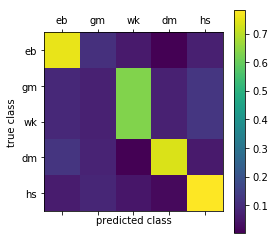

In [23]:
plt.matshow(CMsubsumedto2)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

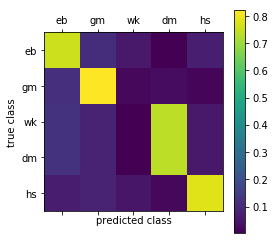

In [24]:
plt.matshow(CMsubsumedfrom2)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

## 3. Metric values

Import the `proclam.Metric` superclass and the metric subclass you want to test.

In [25]:
from proclam.metrics import metric
from proclam.metrics import logloss
from proclam.metrics import brier

### Probabilistic metrics

Let's try out the [logloss metric](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Cross_entropy_loss).  The logloss metric is a sum over $LL_{ij} = -y_{ij}\ln[p_{ij}]$ for predicted probabilities $p$ and true class indicators $y$.

In [26]:
# weights = np.array([0.3,0.15,0.1,0.15,0.3])
weights = np.array([0.0,0.0,1.0,0.0,0.0])

In [27]:
for candidate in [predictionB, predictionC, predictionG, predictionH, predictionI, predictionJ, predictionJ1]:
    D = proclam.metrics.LogLoss()
    performance = D.evaluate(candidate, truth, averaging=weights)
    print('proclam implementation of log-loss: '+str(performance))
    #alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
    #print('scikit-learn implementation of log-loss: '+str(alternative))

#D = proclam.metrics.LogLoss()
#performance = D.evaluate(predictionF, truth_snphotcc, averaging=weights)
#print('proclam implementation of log-loss: '+str(performance))



proclam implementation of log-loss: 1.9467692362663755
proclam implementation of log-loss: 0.5873053661481069
proclam implementation of log-loss: 0.4985535342418646
proclam implementation of log-loss: 3.2716260697307087
proclam implementation of log-loss: 0.8391912085925096
proclam implementation of log-loss: 0.5795189847083857
proclam implementation of log-loss: 4.44547996411847


In [28]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto2': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
LL_metric = proclam.metrics.LogLoss()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = LL_metric.evaluate(pred_competitor, truth, averaging='per_class')
    print(candidate_cm+' logloss = '+str(metval))

tunnel logloss = 1.3831099142162573
broadbrush logloss = 2.147514136377367
cruise logloss = 1.8925640255539373
subsumedto2 logloss = 0.8697035708801626
subsumedfrom logloss = 1.2313487087147357


In [29]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2,'subsumedfrom': CMsubsumedfrom2}
LL_metric = proclam.metrics.LogLoss()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = LL_metric.evaluate(pred_competitor, truth, averaging=weights)
    print(candidate_cm+' logloss = '+str(metval))

tunnel logloss = 0.45996840473970635
broadbrush logloss = 3.3173356388856186
cruise logloss = 0.7884312373010852
subsumedto logloss = 0.5772789861655064
subsumedfrom logloss = 4.401321122622816


Let's try the [Brier score](https://en.wikipedia.org/wiki/Brier_score#Original_definition_by_Brier) this time.  The multi-class Brier score is $BS = \frac{1}{N}\sum\limits _{t=1}^{N}\sum\limits _{i=1}^{R}(f_{ti}-o_{ti})^2$ for $N$ objects, $R$ classes, predicted probabilities $f$, and $o_{i}$ of 1 for true class $i$ and 0 for other true classes.

First we create an instantiation of the metric.  Then, we calculate the metric value.  For binary classes, we can compare to the implementation in `scikit-learn`.

In [30]:
for candidate in [predictionB, predictionC, predictionG, predictionH, predictionI, predictionJ, predictionJ1]:
    E = proclam.metrics.Brier()
    performance = E.evaluate(candidate, truth)
    print('proclam implementation of Brier score: '+str(performance))
    
    if M_classes == 2:
        skl_truth = proclam.metrics.util.truth_reformatter(truth).T[0]
        alternative = skl.metrics.brier_score_loss(skl_truth, prediction.T[0])
        print('scikit-learn implementation: '+str(alternative))
        
# E = proclam.metrics.brier.Brier()
# performance = E.evaluate(predictionF, truth_snphotcc)
# print('proclam implementation of Brier score: '+str(performance))

proclam implementation of Brier score: 0.17481523141779132
proclam implementation of Brier score: 0.03349662221027182
proclam implementation of Brier score: 0.13994060524323776
proclam implementation of Brier score: 0.16442263732364013
proclam implementation of Brier score: 0.19760600980918508
proclam implementation of Brier score: 0.08131350128672857
proclam implementation of Brier score: 0.08047203028278058


In [31]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
B_metric = proclam.metrics.Brier()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = B_metric.evaluate(pred_competitor, truth, averaging='per_class')
    print(candidate_cm+' Brier = '+str(metval))

tunnel Brier = 0.13835879922919994
broadbrush Brier = 0.16647095421593264
cruise Brier = 0.19722890971661755
subsumedto Brier = 0.07719957610858942
subsumedfrom Brier = 0.0838596231599401


In [32]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
B_metric = proclam.metrics.Brier()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = B_metric.evaluate(pred_competitor, truth, averaging=weights)
    print(candidate_cm+' Brier = '+str(metval))

tunnel Brier = 0.03829109430194667
broadbrush Brier = 0.2519580848801754
cruise Brier = 0.07399778110647401
subsumedto Brier = 0.0487604318197624
subsumedfrom Brier = 0.28825253455457156


## Deterministic metrics

Let's check that reducing the probabilities to class point estimates actually does what we want; the one based on a good confusion matrix should do better than the random guesser.  

### True/False positive/negative rates

Let's compare `proclam`'s calculation of the standard rates to that of `pycm`.

In [33]:
detC = proclam.metrics.util.prob_to_det(predictionC)
cmC = proclam.metrics.util.det_to_cm(detC, truth)
print(proclam.metrics.util.cm_to_rate(cmC, vb=True))

rates(TPR=array([0.98113208, 1.        , 0.94117647, 0.95548961, 0.96296296]), FPR=array([0.00527983, 0.00740741, 0.01256281, 0.01357466, 0.01540832]), FNR=array([0.01886792, 0.        , 0.05882353, 0.04451039, 0.03703704]), TNR=array([0.99472017, 0.99259259, 0.98743719, 0.98642534, 0.98459168]), TP=array([ 52.,  55., 192., 322., 338.]), FP=array([ 5.,  7., 10.,  9., 10.]), FN=array([ 1.,  0., 12., 15., 13.]), TN=array([942., 938., 786., 654., 639.]))


In [34]:
compare = ConfusionMatrix(truth, detC)
print(proclam.metrics.util.RateMatrix(TPR=compare.TPR, FPR=compare.FPR, FNR=compare.FNR, TNR=compare.TNR, TP=compare.TP, FP=compare.FP, FN=compare.FN, TN=compare.TN))

rates(TPR={0: 0.9811320754716981, 1: 1.0, 2: 0.9411764705882353, 3: 0.9554896142433235, 4: 0.9629629629629629}, FPR={0: 0.0052798310454065245, 1: 0.007407407407407418, 2: 0.012562814070351758, 3: 0.013574660633484115, 4: 0.015408320493066285}, FNR={0: 0.018867924528301883, 1: 0.0, 2: 0.05882352941176472, 3: 0.04451038575667654, 4: 0.03703703703703709}, TNR={0: 0.9947201689545935, 1: 0.9925925925925926, 2: 0.9874371859296482, 3: 0.9864253393665159, 4: 0.9845916795069337}, TP={0: 52, 1: 55, 2: 192, 3: 322, 4: 338}, FP={0: 5, 1: 7, 2: 10, 3: 9, 4: 10}, FN={0: 1, 1: 0, 2: 12, 3: 15, 4: 13}, TN={0: 942, 1: 938, 2: 786, 3: 654, 4: 639})


### ROC AUC

The ROC is the true positive rate as a function of the false positive rate, where the rates are calculated from a confusion matrix derived by deterministically assigning classes based on a series of threshold values in probability.

In [35]:
ROC_metric = proclam.metrics.ROC()
rocB = ROC_metric.evaluate(predictionB,truth, 0.1, averaging='per_class', vb=False)
rocC = ROC_metric.evaluate(predictionC,truth, 0.1)
print('ROC AUC for prediction B = %.3f'%rocB)
print('ROC AUC for prediction C = %.3f'%rocC)
rocB = ROC_metric.evaluate(predictionB,truth,0.1, averaging=[0.1,0.3,0.2,0.2,0.2])
print('ROC AUC for prediction B with weird weights = %.3f'%rocB)

ROC AUC for prediction B = 0.493
ROC AUC for prediction C = 0.995
ROC AUC for prediction B with weird weights = 0.498


Let's compare the ROC AUC calculated by `proclam` to that of `scikit-learn`.  

In [36]:
# this runs if you change line 78 in roc.py to return auc_class instead of auc_allclass
# truth_score = proclam.metrics.util.det_to_prob(truth)
# from_proclam, proclam_auc, from_skl = [],[],[]
# for m in range(M_classes):
#     fpr, tpr, thresholds = skl.metrics.roc_curve(truth_score.T[m].T.astype(int), predictionB.T[m].T)
#     proclam_says = ROC_metric.evaluate(predictionB, truth, thresholds, vb=True)[m]
#     proclam_auc.append(ROC_metric.evaluate(predictionB, truth, thresholds, vb=False)[m])
#     i = np.argsort(proclam_says[0])
#     new_auc = proclam.metrics.util.auc(proclam_says[0][i], proclam_says[1][i])
#     print('proclam: '+str(new_auc))
#     from_proclam.append(proclam.metrics.util.auc(proclam_says[0], proclam_says[1]))
#     skl_says = proclam.metrics.util.auc(fpr, tpr)
#     print('skl: '+str(skl_says))
#     from_skl.append(skl_says)
# print('proclam says %.3f'%np.mean(proclam_auc)+' scikit-learn says %.3f'%np.mean(from_skl))
# print('proclam says '+str(proclam_auc)+' scikit-learn says '+str(from_skl))

### PRC AUC

The precision is the number of correctly classified positives divided by the number all items classified as positive, whereas the recall is the number of correctly classified positives divided by the number of items whose true class was positive.  

In [37]:
metric = proclam.metrics.PRC()
prB = metric.evaluate(predictionB,truth, 0.01)
prC = metric.evaluate(predictionC,truth, 0.01)

print('Precision/Recall AUC for prediction B = %.3f'%prB)
print('Precision/Recall AUC for prediction C = %.3f'%prC)

/home/aimalz/Code/proclam/proclam/metrics/util.py:455: RuntimeWarning: invalid value encountered in double_scalars
  p = np.asarray(TP / (TP + FP))


Precision/Recall AUC for prediction B = 0.203
Precision/Recall AUC for prediction C = 0.937


In [38]:
# compare = ConfusionMatrix(truth, proclam.metrics.util.prob_to_det(predictionC))
# print((compare.TPR, compare.PPV))

### F-score

In [39]:
prC = metric.evaluate(predictionC,truth, 0.01, vb=True)

In [40]:
metric = proclam.metrics.F1()
fB = metric.evaluate(predictionB,truth)
fC = metric.evaluate(predictionC,truth)

print('f1 score for prediction B = %.3f'%fB)
print('f1 score for prediction C = %.3f'%fC)

f1 score for prediction B = 0.184
f1 score for prediction C = 0.953


In [41]:
# compare = ConfusionMatrix(truth, proclam.metrics.util.prob_to_det(predictionB))
# print((compare.F1))

### Matthews Correlation Coefficient

In [42]:
metric = proclam.metrics.MCC()
mccB = metric.evaluate(predictionB, truth)
mccC = metric.evaluate(predictionC,truth)

print('MCC for prediction B = %.3f'%mccB)
print('MCC for prediction C = %.3f'%mccC)

MCC for prediction B = 0.009
MCC for prediction C = 0.942


In [43]:
# compare = ConfusionMatrix(truth, proclam.metrics.util.prob_to_det(predictionC))
# print((compare.MCC))

### Accuracy

In [44]:
metric = proclam.metrics.Accuracy()
accB = metric.evaluate(predictionB, truth)
accC = metric.evaluate(predictionC,truth)

print('Accuracy for prediction B = %.3f'%accB)
print('Accuracy for prediction C = %.3f'%accC)

Accuracy for prediction B = 0.207
Accuracy for prediction C = 0.968


In [50]:
# compare = ConfusionMatrix(truth, proclam.metrics.util.prob_to_det(predictionB))
# print((compare.ACC))

{0: 0.785, 1: 0.769, 2: 0.675, 3: 0.601, 4: 0.596}


# Next steps

Once there are more simulators, classifiers, and metrics, we'll loop over tests and plot comparisons.  Stay tuned for more!

In [ ]:
# Z = proclam.classifiers.guess.Guess(seed=None)
# predictionZ = Z.classify(M_classes, truth, other=False)
# # print(prediction)
# predictionZ

# for candidate in [predictionZ]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# print(type(predictionZ))
# print(predictionZ.shape)

# rows = [0, 1, 30, 50, 62, 60]
# cols = [0, 2, 4, 1, 0, 0]

# ## fill with fake zeros
# predictionZ_0 = predictionZ
# predictionZ_0[rows,cols] = 0
# predictionZ_0

# for candidate in [predictionZ_0]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# print(np.where(predictionZ_0 < 0.000003))

# predictionZ_1 = predictionZ
# predictionZ_1[rows,cols] = 1
# predictionZ_1

# for candidate in [predictionZ_1]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# np.where(predictionZ_1 > 0.9995)


In [ ]:
# for i in range(1, 100000):
#     print(i)
#     Z = proclam.classifiers.guess.Guess(seed=i)
#     predictionZ = Z.classify(M_classes, truth, other=False)
#     # print(prediction)
#     predictionZ

#     for candidate in [predictionZ]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     # print(type(predictionZ))
#     # print(predictionZ.shape)

#     rows = [0, 1, 30, 50, 62, 60]
#     cols = [0, 2, 4, 1, 0, 0]

#     ## fill with fake zeros
#     predictionZ_0 = predictionZ
#     predictionZ_0[rows,cols] = 0
#     predictionZ_0

#     for candidate in [predictionZ_0]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     np.where(predictionZ_0 < 0.0005)

#     predictionZ_1 = predictionZ
#     predictionZ_1[rows,cols] = 1
#     predictionZ_1

#     for candidate in [predictionZ_1]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     np.where(predictionZ_1 == 1)
#     print("ITER :\n",i)
#     i += 1
